# Predicting Song Popularity#

## Key Takeaways ##

- **A logistic model with a threshold of .45 provides an excellent predictive framework for forecasting whether or not a song will be a Top10 hit.**


- **Multicollinearity can filp coefficient signs and confound results, if not dealt with by removing the variable least likely to explain the underlying phenomenon.**


- **Assessment of model performance must extend beyond accuracy in excess of a baseline model and incorporate an evaluation of both the sensitivity and specificity of the model with respect to the users' objectives.**

### Background Information ###

"The music industry has a well-developed market with a global annual revenue around $15 billion. The recording industry is highly competitive and is dominated by three big production companies which make up nearly 82% of the total annual album sales.

Artists are at the core of the music industry and record labels provide them with the necessary resources to sell their music on a large scale. A record label incurs numerous costs (studio recording, marketing, distribution, and touring) in exchange for a percentage of the profits from album sales, singles and concert tickets.

Unfortunately, the success of an artist's release is highly uncertain: a single may be extremely popular, resulting in widespread radio play and digital downloads, while another single may turn out quite unpopular, and therefore unprofitable.

Knowing the competitive nature of the recording industry, record labels face the fundamental decision problem of which musical releases to support to maximize their financial success."

(source: MITx)

### The Problem ###

Can data analytics predict the popularity of a song? Here, we endeavor to predict whether a song will garner a top 10 spot on the Billboard Hot 100 Chart.

### The Data ###

Our dataset consists of 1) all songs that made it into the top 10 of the Billboard Hot 100 from 1990-2010 and 2) a sampling of songs that failed to do so. The data were culled from three sources: Wikipedia, Billboard.com, and EchoNest.

We will predict song popularity as a function of its properties. The variables included in the dataset either describe the artist or the song. The specific variables are as follows:

**year**: the year the song was released

**songtitle**: the title of the song

**artistname**: the name of the artist of the song

**songID and artistID**: identifying variables for the song and artist

**timesignature and timesignature_confidence**: a variable estimating the time signature of the song, and the confidence in the estimate

**loudness**: a continuous variable indicating the average amplitude of the audio in decibels

**tempo and tempo_confidence**: a variable indicating the estimated beats per minute of the song, and the confidence in the estimate

**key and key_confidence**: a variable with twelve levels indicating the estimated key of the song (C, C#, . . ., B), and the confidence in the estimate

**energy**: a variable that represents the overall acoustic energy of the song, using a mix of features such as loudness

**pitch**: a continuous variable that indicates the pitch of the song

**timbre_0_min, timbre_0_max, timbre_1_min, timbre_1_max, . . . , timbre_11_min, and timbre_11_max**: variables that indicate the minimum/maximum values over all segments for each of the twelve values in the timbre vector (resulting in 24 continuous variables)

**Top10**: a binary variable indicating whether or not the song made it to the Top 10 of the Billboard Hot 100 Chart (1 if it was in the top 10, and 0 if it was not)

(source: MITx)

In [1]:
install.packages("ggplot2")
install.packages("corrplot")
install.packages("tidyverse")
install.packages("caTools")
install.packages("ROCR")
install.packages("data.table")
install.packages("wesanderson")
library(caTools)
library(wesanderson)
library(tidyverse)
library(corrplot)
library(ggplot2)
library(ROCR)
library(data.table)

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.1     ✔ purrr   0.3.2
✔ tibble  2.1.1     ✔ dplyr   0.8.3
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag(

In [2]:
songs = read.csv('songs.csv')

### Data Structure ###

In [3]:
str(songs)

'data.frame':	7574 obs. of  39 variables:
 $ year                    : int  2010 2010 2010 2010 2010 2010 2010 2010 2010 2010 ...
 $ songtitle               : Factor w/ 7141 levels "̈́ l'or_e des bois",..: 6204 5522 241 3115 48 608 255 4419 2886 6756 ...
 $ artistname              : Factor w/ 1032 levels "50 Cent","98 Degrees",..: 3 3 3 3 3 3 3 3 3 12 ...
 $ songID                  : Factor w/ 7549 levels "SOAACNI1315CD4AC42",..: 595 5439 5252 1716 3431 1020 1831 3964 6904 2473 ...
 $ artistID                : Factor w/ 1047 levels "AR00B1I1187FB433EB",..: 671 671 671 671 671 671 671 671 671 507 ...
 $ timesignature           : int  3 4 4 4 4 4 4 4 4 4 ...
 $ timesignature_confidence: num  0.853 1 1 1 0.788 1 0.968 0.861 0.622 0.938 ...
 $ loudness                : num  -4.26 -4.05 -3.57 -3.81 -4.71 ...
 $ tempo                   : num  91.5 140 160.5 97.5 140.1 ...
 $ tempo_confidence        : num  0.953 0.921 0.489 0.794 0.286 0.347 0.273 0.83 0.018 0.929 ...
 $ key                   

### Data Summary ###

In [4]:
summary(songs)

      year          songtitle              artistname  
 Min.   :1990   Intro    :  15   Various artists: 162  
 1st Qu.:1997   Forever  :   8   Anal Cunt      :  49  
 Median :2002   Home     :   7   Various Artists:  44  
 Mean   :2001   Goodbye  :   6   Tori Amos      :  41  
 3rd Qu.:2006   Again    :   5   Eels           :  37  
 Max.   :2010   Beautiful:   5   Napalm Death   :  37  
                (Other)  :7528   (Other)        :7204  
                songID                   artistID    timesignature  
 SOALSZJ1370F1A7C75:   2   ARAGWS81187FB3F768: 222   Min.   :0.000  
 SOANPAC13936E0B640:   2   ARL14X91187FB4CF14:  49   1st Qu.:4.000  
 SOBDGMX12B0B80808E:   2   AR4KS8C1187FB4CF3D:  41   Median :4.000  
 SOBUDCZ12A58A80013:   2   AR0JZZ01187B9B2C99:  37   Mean   :3.894  
 SODFRLK13134387FB5:   2   ARZGTK71187B9AC7F5:  37   3rd Qu.:4.000  
 SOEJPOK12A6D4FAFE4:   2   AR95XYH1187FB53951:  31   Max.   :7.000  
 (Other)           :7562   (Other)           :7157                  


### Exploratory Data Analysis ###

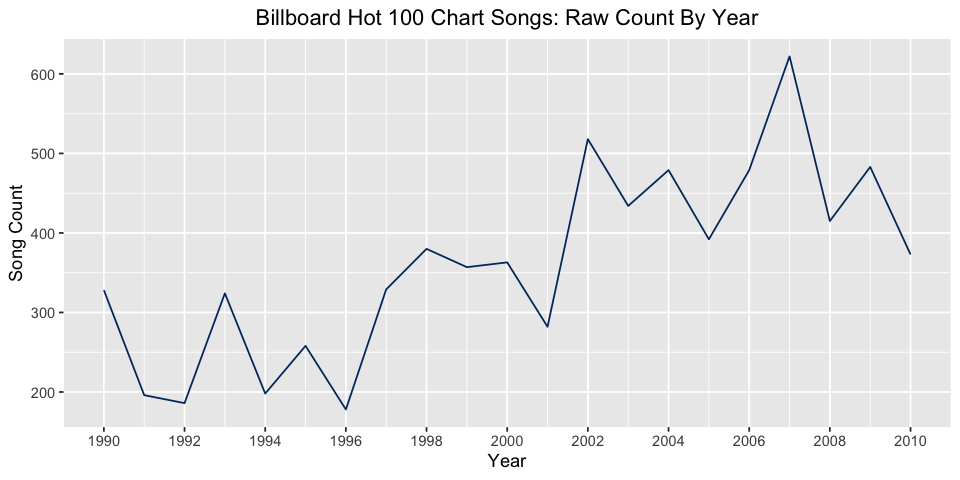

In [5]:
songs_by_year = songs %>%
    select(year) %>%
    group_by(year) %>%
    tally()
options(repr.plot.width=8, repr.plot.height=4)
ggplot(songs_by_year, aes(x = year, y = n)) + 
    geom_line(colour="#00356B") + 
    scale_x_continuous(breaks=seq(1990,2010,2)) +
    labs(x="Year", y="Song Count") +
    ggtitle("Billboard Hot 100 Chart Songs: Raw Count By Year") +
    theme(plot.title = element_text(hjust=.5))

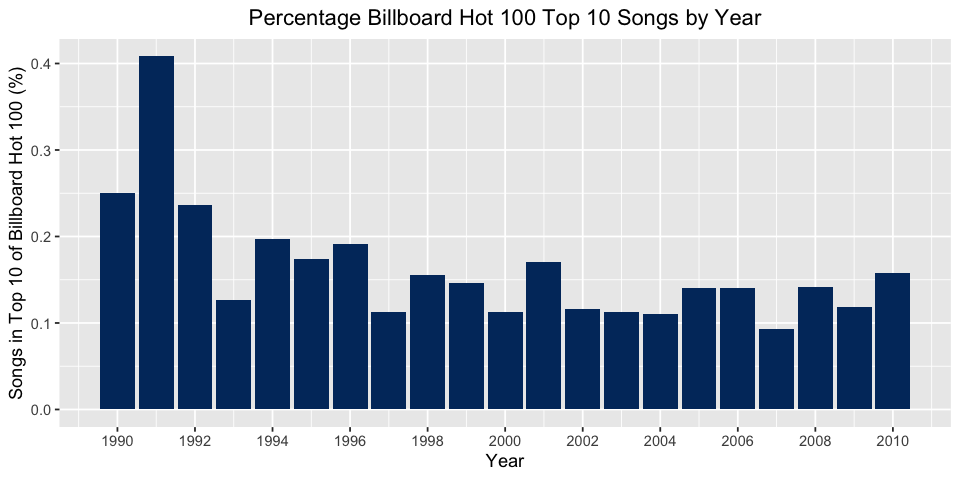

In [6]:
Pct_Top10_by_year = songs %>%
    group_by(year, Top10) %>%
    summarise (n = n()) %>%
    mutate(Percentage = n / sum(n)) %>%
    filter(Top10==1)
options(repr.plot.width=8, repr.plot.height=4)
ggplot(Pct_Top10_by_year, aes(x = year, y = Percentage)) + 
    geom_bar(stat='identity', fill="#00356B") +
    ggtitle("Percentage Billboard Hot 100 Top 10 Songs by Year") +
    theme(plot.title = element_text(hjust=.5)) +
    xlab("Year") +
    ylab("Songs in Top 10 of Billboard Hot 100 (%)") +
    scale_x_continuous(breaks=seq(1990,2010,2))

In [ ]:
cols = c(names(songs)[6:38])
corr_subset = songs %>%
    select(cols)

In [ ]:
corrplot(cor(corr_subset, use="complete.obs"))

Our data set is largely free of multicollinearity, with the exception of three variables: timbre_0_max, loudness, and energy. We will drop at least one of these prior to finalizing our model.

Our data set ends in 2010. It might be interesting to find out how many songs came out that year.

In [ ]:
songs_2010 = table(songs$year==2010)[[2]]
cat(paste(songs_2010, "songs were released in 2010."))

Michael Jackson was a prolific, and popular, song writer both before and during the period under consideration. As it so happens, he released 18 songs in our dataset.

In [ ]:
songs_MJ = table(songs$artistname=="Michael Jackson")[[2]]
cat(paste(songs_MJ, "songs were released by Michael Jackson."))

Since our study focuses on song popularity, we should take a moment to find out what songs, if any, by Michael Jackson made the top 10.

In [ ]:
MJ_subset = subset(songs, artistname=="Michael Jackson")
songs_10 = MJ_subset[c("songtitle", "Top10")]
songs_10

It looks like Michael Jackson had 5 songs in the Top 10 over the period covered by our data set.

We find it interesting that our data set contains time signature as a variable. This is a musical trait considered by all who play in an ensemble, but rarely by those who simply listen to music. If this variable affects song popularity, it would be at a subconscious level, which would be fascinating.

In [ ]:
table(songs$timesignature)

As shown above, our 'timesignature' variable takes on the following values: 0,1,3,4,5,7. Four is the most popular signature. 

Sometimes one is simply in the mood to hit the dance floor and throw down. When this is the case, it's best to have a DJ spinning a song with a fast tempo (measured in beats per minute). 

In [ ]:
fastest_song=songs$songtitle[which.max(songs$tempo)]
cat(paste("The song with the fastest tempo is", fastest_song))

## The Model##

Our response variable is a binary classification. Hence, a logistic regression framework is a reasonable choice for modeling whether or not a song will be in the Top10. This model will include only those variables that describe the numerical properties of the songs in our dataset.

In [ ]:
train = subset(songs, year <= 2009)
test = subset(songs, year == 2010)

In [ ]:
exclusions = c('year', 'songtitle', 'artistname', 'songID', 'artistID')
train2 = train[,!(names(train)%in% exclusions)]
test2 = test[,!(names(test) %in% exclusions)]

In [ ]:
str(test2)

In [ ]:
logistic1 = glm(Top10 ~ ., data=train2, family=binomial)

In [ ]:
summary(logistic1)

***Initial Observations:***
- Higher key_confidence, timesignature_confidence, & tempo_confidence leads to a higher likelihood a song will land in the Top 10.
- Lower key_confidence, timesignature_confidence, & tempo_confidence is the hallmark of songs that are less complex. The coefficients on these variables are low, so the typical mainstream song preferred by listeners most likely lacks complexity.
- Songs with heavy instrumentation tend to be loud and often energetic.  The coefficient for loudness supports the notion that listeners enjoy this trait, however, the coefficient for energy does not. Multicollinearity could be at play. 

In [ ]:
correl = cor(train2$loudness, train2$energy)
cat(paste("The correlation between 'loudness' & 'energy':", round(correl,4)))

Multicollinearity is indeed at work within our model and either loudness or energy must go. We will try eliminating loudness simply because loud songs are not necessarily good songs. 

In [ ]:
logistic2 = glm(Top10 ~ . -loudness, data=train2, family=binomial)

In [ ]:
summary(logistic2)

The removal of our 'loudness' variable from the model swung the coefficient for 'energy' in the right direction, however, it is no longer significant. Moreover, our AIC increased from 4827.2 to 4937.8. This indicates we now have an inferior model. We'll now see what happens when we keep 'loudness' in our model and eliminate 'energy'. 

In [ ]:
logistic3 = glm(Top10 ~ . -energy, data=train2, family=binomial)

In [ ]:
summary(logistic3)

While our AIC increased marginally from 4827.2 to 4848.7, indicating a slight decline in model quality, removing the 'energy' term from the model eliminated our multicollinearity issue and left us with our highly significant 'loudness' variable. Thus, the slight increase in AIC seems worth it. 

### Out-of-Sample Testing ###

In [ ]:
logistic3_pred = predict(logistic3, newdata=test2, type='response')

**Confusion Matrix Calculation & Accuracy**

In [ ]:
confusion_mtx = function(df, observed_y, predicted_y, threshold) {
    
    # Input: dataframe, response variable name as string, vector of 
    # predicted values, threshold value
    # 
    # Output: Confusion matrix to assess model performance
    
    cmtx=table(df[[observed_y]], predicted_y > threshold)
    
    return (cmtx)
}


In [ ]:
cmtx=confusion_mtx(test2, 'Top10', logistic3_pred, .45)
addmargins(cmtx)

In [ ]:
confusion_accuracy = function(confusion_matrix) {
    
    # Input: confusion matrix
    #
    # Output: Message stating the accuracy of the model based on the data
    # contained in the matrix.
    
    accuracy = sum(diag(prop.table(confusion_matrix)))
    
    return (cat(paste("Based on the confusion matrix, the out-of-sample accuracy of our model is", round(accuracy,4)*100, "%.")))
}

confusion_accuracy(cmtx)

Our model's out-of-sample accuracy of 87.94% seems like a decent result, but how does it compare to the baseline prediction derived from the test set?

In [ ]:
cat(paste("Our baseline model has an accuracy of ", round(table(test2$Top10)[[1]]/(table(test2$Top10)[[1]]+table(test2$Top10)[[2]]),4)*100),"%.")

It looks like we definitely took a step in the right direction, but was it worth it?

### Model Validation ###

Recall that our objective is to predict a Top10 hit. Our baseline model fails in this regard. It predicts the most frequent outcome, which is that a song ****will not**** become a hit. A record company would most definitely be interested in a model that could predict a Top10 hit, while minimizing the potential for investment losses.

Looking at our confusion matrix for our third model, we see that it accurately predicts that 19 songs will be Top10 hits and inaccurately predicts only 5 songs will be in the Top10.  This represents a decisive improvement over the baseline model.  

In [ ]:
cmtx=confusion_mtx(test2, 'Top10', logistic3_pred, .45)
addmargins(cmtx)

In [ ]:
sensitivity = function(confusion_mtx) {
    #Input: 2x2 Confusion Matrix
    #
    #Output: The sensitivity/true positive rate of the matrix
    
    true_poz_rate = (confusion_mtx[[4]]/(confusion_mtx[[2]]+confusion_mtx[[4]]))
    return (true_poz_rate)
}

cat(paste("Our model has a sensitivity (true positive rate) of ", round(sensitivity(cmtx),4)*100),"%.")

In [ ]:
specificity = function(confusion_mtx) {
    #Input: 2x2 Confusion Matrix
    #
    #Output: The specificity/true negative rate of the matrix
    
    true_neg_rate = (confusion_mtx[[1]]/(confusion_mtx[[1]]+confusion_mtx[[3]]))
    return (true_neg_rate)
}
cat(paste("Our model has a specificity (true negative rate) of ", round(specificity(cmtx),4)*100),"%.")

The above results indicate our model favors specificity over sensitvity. This implies our model rather conservative when predicting Top10 hits with a threshold of .45, doing so rarely. The model, therefore, seems quite useful and represents a distinct edge over the baseline approach.  